**Brian Blaylock**  
**March 21, 2019**

# GLM Events on HRRR grid Contingency Table

1. Get HRRR Lightning (LTNG) data and lat/lon grid
2. Get GLM Events for the previous hour.
3. Filter Events to HRRR Path
    - A rough filter for definate not in the HRRR domain
    - A fine filter to account for the curvature of the map projection
4. Map the GLM events onto the HRRR grid.
5. Apply a spatial filter to bloat (upscale) the number of HRRR grid points that witness each GLM event.

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')

from BB_HRRR.HRRR_Pando import get_hrrr_latlon,\
                               get_hrrr_variable
from BB_GOES.get_GLM import get_GLM_file_nearesttime,\
                            accumulate_GLM_FAST,\
                            bin_GLM_on_HRRR_grid

from BB_maps.my_basemap import draw_HRRR_map,\
                               draw_centermap

from BB_HRRR.HRRR_paths import get_paths

----

In [2]:
#DATE = datetime(2018, 5, 14, 22) # Mallard Fire
#DATE = datetime(2018, 7, 5, 23) # Lake Christine
DATE = datetime(2018, 7, 17, 6) # July Storm
#DATE = datetime(2018, 7, 27, 0) # Missing GLM data

validDATE = DATE
fxx = 1
runDATE = validDATE - timedelta(hours=fxx)

In [3]:
m = draw_HRRR_map()

In [4]:
mUtah = draw_centermap(center='Utah', size=(4,6))

In [5]:
mColorado = draw_centermap(center='Colorado', size=(4,6))

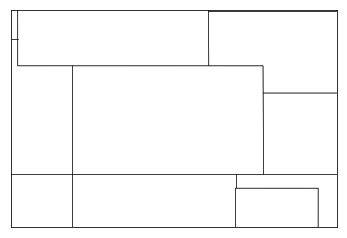

In [6]:
mColorado.drawstates()

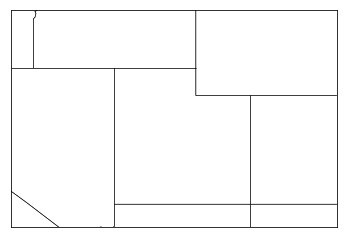

In [7]:
mUtah.drawstates()

In [8]:
mTexas = draw_centermap((33.423575, -100.635537), size=(4,4))

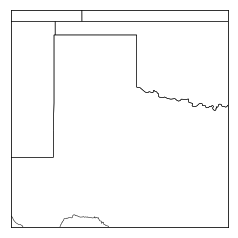

In [9]:
mTexas.drawstates()
mTexas.drawcountries()
mTexas.drawcoastlines()

## 1) Get HRRR Lightning data and lat/lon grid

In [10]:
## 1) Get HRRR Lightning data and lat/lon grid.
Hlat, Hlon = get_hrrr_latlon(DICT=False)
H = get_hrrr_variable(runDATE, 'LTNG:entire', fxx=fxx, verbose=False)

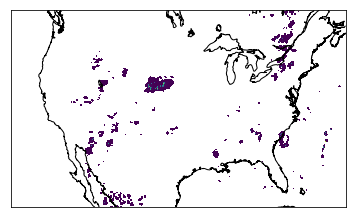

In [11]:
m.pcolormesh(Hlon, Hlat, H['value'], latlon=True)
m.drawcoastlines()

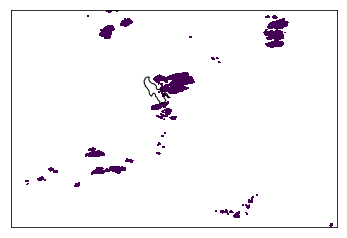

In [12]:
mUtah.pcolormesh(Hlon, Hlat, H['value'], latlon=True)
mUtah.drawcoastlines()

# 2) Get GLM Events for the previous hour

In [13]:
## 2) Get GLM Events for the previous hour.
files = get_GLM_file_nearesttime(validDATE-timedelta(minutes=30), window=30, verbose=False)
E = accumulate_GLM_FAST(files, data_type='event', verbose=False)

-->> Accumulate GLM FAST MP: 65.0%

In [14]:
print('\nGot %s of %s expected files.' % (files['Number'], files['Number Expected']))
print('Total Events: {:,}'.format(len(E['longitude'])))


Got 180 of 180 expected files.
Total Events: 2,258,485


# 3) Filter Events to HRRR Path and 4) Grid the GLM data on the HRRR domain.

In [15]:
hist, filtered = bin_GLM_on_HRRR_grid(E, Hlat, Hlon, m)

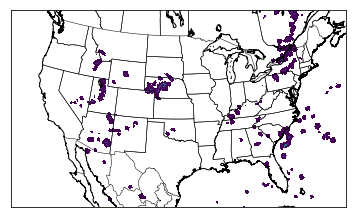

In [16]:
m.pcolormesh(Hlon, Hlat, hist, latlon=True)
m.drawstates(); m.drawcoastlines(); m.drawcountries()

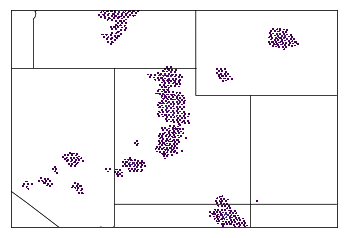

In [16]:
mUtah.pcolormesh(Hlon, Hlat, hist, latlon=True)
mUtah.drawstates()

# 4) Bloat the GLM data footprint to account for GLM's coarse resolution 

In [18]:
##=============================================================================
## 5) Apply a spatial filter to bloat (enlarge or upscale) the number of HRRR
#     grid points that witness each GLM event.
# The GLM instrument has a resolution of only ~14 km. That is much more coarse
# than the 3 km HRRR grid we just mapped the GLM data onto. If you plotted the
# results of histogram, you would see the data is polkadoted like a speckled
# sussex chicken. We now apply a spatial filter that will fill in the gaps.

def radial_footprint(radius):
    """Specify a radial footprint"""
    y, x = np.ogrid[-radius: radius+1, -radius: radius+1]
    footprint = x**2 + y**2 <= radius**2
    footprint = 1*footprint.astype(float)
    return footprint

def neighborhood_max(values):
    return np.max(values)

In [35]:
radius = 2
bloat_glm = ndimage.generic_filter(hist, np.max, footprint=radial_footprint(radius))

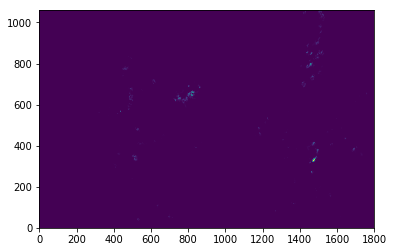

In [37]:
plt.pcolormesh(bloat_glm)

In [32]:
custom = np.array([[0,1,1,1,0],
                   [1,1,1,1,1],
                   [1,1,1,1,1],
                   [1,1,1,1,1],
                   [0,1,1,1,0]])
bloat_glm = ndimage.generic_filter(hist, neighborhood_max, footprint=custom)

In [85]:
import json
from matplotlib.path import Path
def get_domains():
    # Get HRRR latitude and longitude grids
    Hlat, Hlon = get_hrrr_latlon(DICT=False)

    ## Create Path boundaries of HRRR domain and subdomains of interest:
    # HRRR: All points counter-clockwise around the model domain.
    # West, Central, East: A 16 degree wide and 26 degree tall boundary region.
    GeoJSON_Path = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/geojson_area/'

    domains = {
        'HRRR':
            {'lon': np.concatenate([Hlon[0], Hlon[:,-1], Hlon[-1][::-1], Hlon[:,0][::-1]]),
            'lat': np.concatenate([Hlat[0], Hlat[:,-1], Hlat[-1][::-1], Hlat[:,0][::-1]])},
        'West':{
            'lon':[-120, -104, -104, -120, -120],
            'lat':[24.4, 24.4, 50.2, 50.2, 24.2]},
        'Central':{
            'lon':[-104, -88, -88, -104, -104],
            'lat':[24.4, 24.4, 50.2, 50.2, 24.2]},
        'East':{
            'lon':[-88, -72, -72, -88, -88],
            'lat':[24.4, 24.4, 50.2, 50.2, 24.2]},
        'Utah':{
            'lon':np.array(json.loads(open(GeoJSON_Path+'UT.geo.json', 'r').read())['features'][0]['geometry']['coordinates'][0])[:,0],
            'lat':np.array(json.loads(open(GeoJSON_Path+'UT.geo.json', 'r').read())['features'][0]['geometry']['coordinates'][0])[:,1],},
    }

    
    for i in domains:
        ## Generate Path objects from the vertices.
        domains[i]['path'] = Path(list(zip(domains[i]['lon'], domains[i]['lat'])))
        
        ## Generate mask from the path
        if i == 'HRRR':
            domains[i]['mask'] = np.zeros_like(Hlon)==1
        else:
            in_path = domains[i]['path'].contains_points(list(zip(Hlon.flatten(), Hlat.flatten())))
            not_in_path = np.invert(in_path)
            not_in_path = not_in_path.reshape(np.shape(Hlat))
            domains[i]['mask'] = not_in_path


    return domains
domains = get_domains()

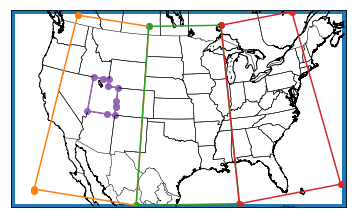

In [86]:
for i in domains:
    m.plot(domains[i]['lon'], domains[i]['lat'], latlon=True)
    m.scatter(domains[i]['lon'], domains[i]['lat'], latlon=True)
m.drawstates()
m.drawcoastlines()
m.drawcountries()

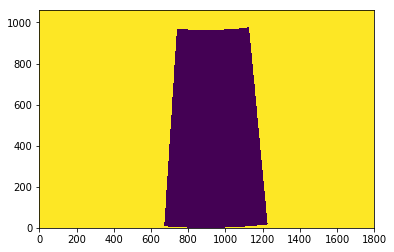

In [91]:
plt.pcolormesh(domains['Central']['mask'])

In [64]:
PATH_masks = {}
for i in PATHS:
    if i == 'HRRR':
        PATH_masks[i] = np.zeros_like(Hlon)
    else:
        in_path = PATHS[i].contains_points(list(zip(Hlon.flatten(), Hlat.flatten())))
        not_in_path = np.invert(in_path)
        not_in_path = not_in_path.reshape(np.shape(Hlat))
        PATH_masks[i] = not_in_path

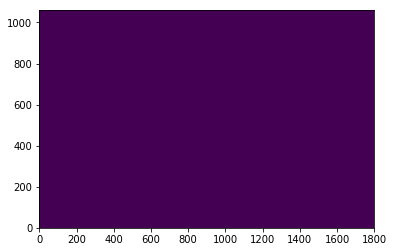

In [66]:
plt.pcolormesh(PATH_masks['HRRR'])

In [92]:
return_this = {'table': {},
                   'Observed Binary': 1,
                   'Forecast Binary': 1,
                   'Number GLM Events': 1,
                   'Number GLM Files': 1,
                   'Number Expected Files': 1}

In [99]:
len(E['latitude'])

2258485

In [102]:
hist, filtered = bin_GLM_on_HRRR_grid(E, Hlat, Hlon, m)

In [136]:
return_this= {'Number Events': {}}
for DOMAIN in domains:
        # Get hist for the masked domains
        hist_domain = np.ma.array(hist, mask=domains[DOMAIN]['mask'])
        num_events = np.sum(hist_domain, dtype=int)
        return_this['Number Events'][DOMAIN] = num_events
        print('{:>15,} events in {:}'.format(num_events, DOMAIN))

        503,763 events in HRRR
         74,114 events in West
        146,181 events in Central
        260,473 events in East
         22,786 events in Utah


In [137]:
return_this

{'Number Events': {'HRRR': 503763,
  'West': 74114,
  'Central': 146181,
  'East': 260473,
  'Utah': 22786}}

In [96]:
return_this['table']

{'HRRR': (1, 2, 3, 4),
 'West': (1, 2, 3, 4),
 'Central': (1, 2, 3, 4),
 'East': (1, 2, 3, 4),
 'Utah': (1, 2, 3, 4)}

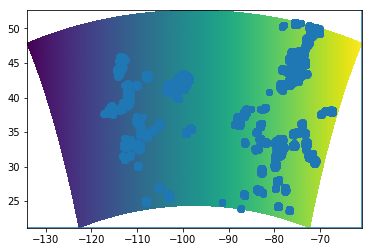

In [38]:
plt.pcolormesh(Hlon, Hlat, Hlon)

#plt.scatter(E['longitude'],
#            E['latitude'])

plt.scatter(E['longitude'][filtered],
            E['latitude'][filtered])

plt.axhline(Hlat.min())
plt.axvline(Hlon.max())

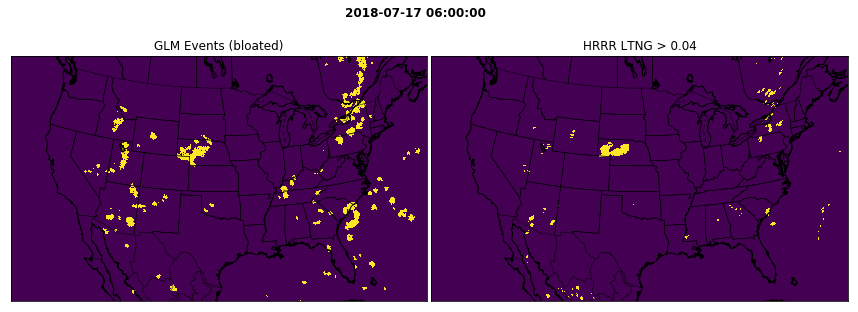

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

plt.sca(ax1)
m.pcolormesh(Hlon, Hlat, bloated_glm.data>1, latlon=True)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
plt.title('GLM Events (bloated)')

plt.sca(ax2)
m.pcolormesh(Hlon, Hlat, H['value'].data>0.04, latlon=True)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
plt.title('HRRR LTNG > 0.04')

plt.suptitle(validDATE, fontweight='semibold')
plt.subplots_adjust(wspace=.01, hspace=.01)

Text(0.5,1,'2018-07-17 06:00:00')

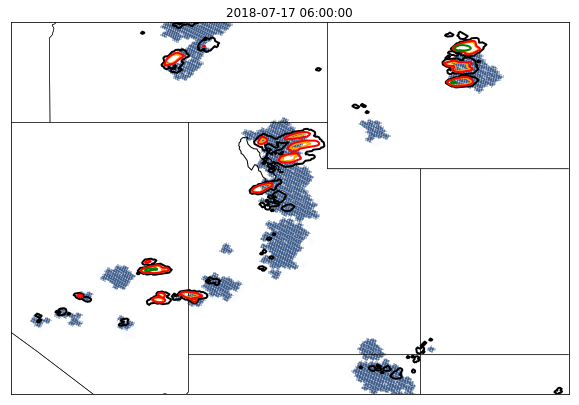

In [85]:
M = mUtah

plt.figure(figsize=(10,10))

#t1 = np.ma.array(bloated_glm, mask=bloated_glm==0)
#t2 = np.ma.array(bloated_glm, mask=bloated_glm<2)

#M.pcolormesh(Hlon, Hlat, t1, latlon=True, cmap='Blues_r', alpha=.3)
M.pcolormesh(Hlon, Hlat, Observed_binary,
                  latlon=True, cmap='Blues', alpha=.3)


M.drawstates(); M.drawcoastlines(); M.drawcountries()

M.contour(Hlon, Hlat, H['value'].data,
                   levels=[.0001], linewidths=2, colors='k',
                   latlon=True)
M.contour(Hlon, Hlat, H['value'].data,
                   levels=[.05], linewidths=2, colors='orange',
                   latlon=True)
M.contour(Hlon, Hlat, H['value'].data,
                   levels=[.04], linewidths=2, colors='r',
                   latlon=True)
M.contour(Hlon, Hlat, H['value'].data,
                   levels=[.11], linewidths=2, colors='g',
                   latlon=True)

#M.contour(Hlon, Hlat, H['value'].data,
#                   levels=[.06], linewidths=2, colors='b',
#                   latlon=True)

plt.title(validDATE)

In [86]:
def contingency_table(Forecasted_binary, Observed_binary):
    '''
    Return the contingency table values of a, b, c, and d for two binary fields.

    Input: 
        Forecasted_binary - array of True/False if the event was forecasted
        Observed_binary   - array of True/False if the event was observed
    '''
    # a) Hits:                  Where forecasted and observed
    a = np.sum(np.logical_and(Forecasted_binary, Observed_binary))

    # b) False Alarm:           Where forecasted, but not observed
    b = np.sum(Forecasted_binary) - a

    # c) Misses                 Where observed, but not forecasted
    c = np.sum(Observed_binary) - a

    # d) Correct Rejection:     Where not forecasted and not observed
    d = np.sum(np.logical_and(Forecasted_binary==False, Observed_binary==False))
    
    return a, b, c, d

def print_contingency_table(a, b, c, d):
    print('          {:^20}'.format('Observed'))
    print('         |{:^10}{:^10}| {:}'.format('Yes', 'No', 'Total'))
    print('--------------------------------------------')
    print(' Fxx Yes |{:10,}{:10,}| {:10,}'.format(a, b, a+b))
    print(' Fxx No  |{:10,}{:10,}| {:10,}'.format(c, d, c+d))
    print('--------------------------------------------')
    print('Total    |{:10,}{:10,}| {:10,}'.format(a+c, b+d, a+b+c+d))
    print('\n')

In [88]:
##=============================================================================
## 6) Compute the contingency table

# HRRR binary field (yes/no lightning). Based on a threshold of 0.04, which 
# means the maximum flashes is 0.05 flashes/km2/5min. Since each grid box is
# 9 km2, this value equates to 0.45 flashes/gridbox/5min (because 0.05 * 9).
# If the maximum lightning was sustained for the entire hour, we would expect 6
# flashes in that grid box.
# This threshold was used because it got rid of the popcorn thunderstorms with
# very low values without shrinking the area of forecasted lightning too much.
 
Forecasted_binary = H['value'].data >= 0.04 # flashes/km2/5min
Observed_binary = bloated_glm > 1         # Only use when more than 1 event

a, b, c, d = contingency_table(Forecasted_binary, Observed_binary)

# n) Total Number
n = a+b+c+d

# a+b) Total Forecasted
total_forecasted = np.sum(Forecasted_binary)

# a+c) Total Observed
total_observed = np.sum(Observed_binary)

# Checks 
total_grid_points = np.size(Forecasted_binary)
print('Total Grid Points == a+b+c+d: %s' % (total_grid_points == n))
print('Total Forecasted == a+b: %s' % (total_forecasted == a+b))
print('Total Observed == a+c: %s' % (total_observed == a+c))
print('\n\n')

print_contingency_table(a, b, c, d)

hit_rate = a/(a+c)
false_alarm_rate = b/(b+d)
false_alarm_ratio = b/(a+b)
proportion_correct = (a+d)/n

print('Hit Rate: {:.2f}%'.format(hit_rate*100))
print('False Alarm Rate: {:.2f}%'.format(false_alarm_rate*100))
print('False Alarm Ratio: {:.2f}%'.format(false_alarm_ratio*100))
print('Proportion Correct: {:.2f}%'.format(proportion_correct*100))

Total Grid Points == a+b+c+d: False
Total Forecasted == a+b: True
Total Observed == a+c: True



                Observed      
         |   Yes        No    | Total
--------------------------------------------
 Fxx Yes |     7,064     5,664|     12,728
 Fxx No  |    41,412     7,926|     49,338
--------------------------------------------
Total    |    48,476    13,590|     62,066


Hit Rate: 14.57%
False Alarm Rate: 41.68%
False Alarm Ratio: 44.50%
Proportion Correct: 24.15%


In [89]:
HIT_RATES = []
FA_RATIOS = []
THRESHOLDS = np.unique(H['value'].data)[1:]

Observed_binary = bloated_glm > 1         # Only use when more than 1 event

for i in THRESHOLDS:
    Forecasted_binary = H['value'].data >= i # flashes/km2/5min
    
    a, b, c, d = contingency_table(Forecasted_binary, Observed_binary)
    
    HIT_RATES.append(a/(a+c))
    FA_RATIOS.append(b/(a+b))

HIT_RATES = np.array(HIT_RATES)
FA_RATIOS = np.array(FA_RATIOS)

In [90]:
#THRESHOLDS

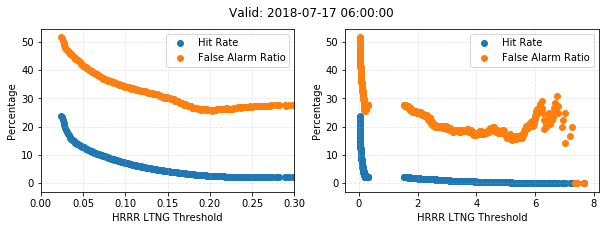

In [93]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3))

plt.suptitle('Valid: %s' % validDATE)

plt.sca(ax1)
plt.scatter(THRESHOLDS, HIT_RATES*100, label='Hit Rate')
plt.scatter(THRESHOLDS, FA_RATIOS*100, label='False Alarm Ratio')
plt.ylabel('Percentage')
plt.xlabel("HRRR LTNG Threshold")
#plt.xticks(THRESHOLDS[::3]);
plt.xlim([0,.3])
plt.legend()
plt.grid(linestyle='--', alpha=.3)

plt.sca(ax2)
plt.scatter(THRESHOLDS, HIT_RATES*100, label='Hit Rate')
plt.scatter(THRESHOLDS, FA_RATIOS*100, label='False Alarm Ratio')
plt.ylabel('Percentage')
plt.xlabel("HRRR LTNG Threshold")
#plt.xticks(THRESHOLDS[::3]);
#plt.xlim([0,.3])
plt.legend()
plt.grid(linestyle='--', alpha=.3)

In [102]:
np.unique(H['value'].data)[1:500]

array([0.024     , 0.025     , 0.026     , 0.027     , 0.028     ,
       0.029     , 0.03      , 0.031     , 0.032     , 0.033     ,
       0.034     , 0.035     , 0.036     , 0.037     , 0.038     ,
       0.039     , 0.04      , 0.041     , 0.042     , 0.043     ,
       0.044     , 0.045     , 0.046     , 0.047     , 0.048     ,
       0.049     , 0.05      , 0.051     , 0.052     , 0.053     ,
       0.054     , 0.055     , 0.056     , 0.057     , 0.058     ,
       0.059     , 0.06      , 0.061     , 0.062     , 0.063     ,
       0.064     , 0.06500001, 0.066     , 0.067     , 0.068     ,
       0.06900001, 0.07      , 0.071     , 0.072     , 0.07300001,
       0.074     , 0.075     , 0.07600001, 0.07700001, 0.078     ,
       0.079     , 0.08000001, 0.081     , 0.082     , 0.083     ,
       0.08400001, 0.085     , 0.086     , 0.087     , 0.08800001,
       0.089     , 0.09      , 0.09100001, 0.09200001, 0.093     ,
       0.094     , 0.09500001, 0.096     , 0.097     , 0.098  